# 3장 분류
## EPOCH 3기 한우림

### 3.1 MNIST
- 손으로 쓴 7만개의 작은 숫자 이미지 데이터셋

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


- 이미지 70,000장, 특성 784개
- 이미지: 28*28(=784) 픽셀, 0(흰색)~255(검은색)


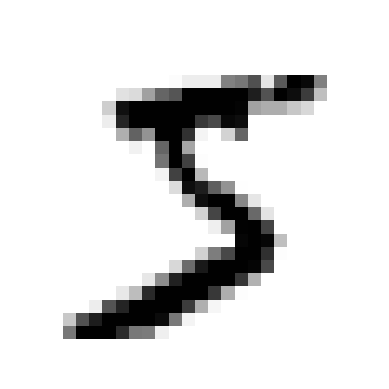

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

- 5로 보이는 이미지의 실제 레이블: 5

In [ ]:
import numpy as np
y = y.astype(np.uint8)

In [ ]:
# train, test split (6만, 1만장씩)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

In [ ]:
# SGD 분류기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

### 3.3 성능 측정

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 1번 연습문제
1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도 달성\
hint: KNightborsClassifier 사용, weights, n_neighbors 하이퍼파라미터로 그리드 탐색 시도

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.9688

In [ ]:
from sklearn.model_selection import GridSearchCV

params = [
    {'weights':["uniform", "distance"],
     'n_neighbors':[3,4,5]}
]


grid = GridSearchCV(clf, param_grid=params, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

- 위 코드 돌리는 데 20분 소요...

In [ ]:
# 최적의 하이퍼파라미터값
grid.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### 2번 연습문제
2. MNIST 이미지를 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 만들기 -> 훈련 세트에 있는 각 이미지에 대해 네 개의 이동된 복사본을 만들어 훈련세트에 추가 -> 확장된 데이터셋에서 최선의 모델을 훈련시키고 테스트셋에서 정확도 측정하기

In [ ]:
from scipy.ndimage import shift

# 픽셀 이동 함수 생성
def aug(img, x, y):
  img.reshape((28,28))
  aug_img = shift(img, [y,x], cval=0, mode="constant")
  return aug_img.reshape((28,28))

In [ ]:
image = X_train[1234]
image = image.reshape((28, 28))

sht_img_down = aug(image, 0, 5)
sht_img_left = aug(image, -5, 0)

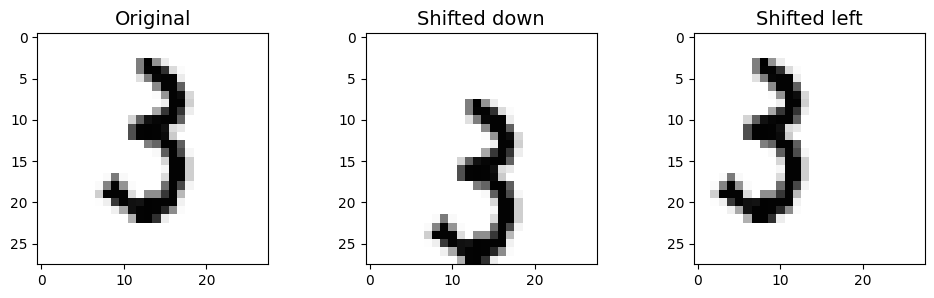

In [ ]:
# 픽셀 이동된 이미지 확인
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(sht_img_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(sht_img_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
# 데이터 확장
X_train_expanded = []
y_train_expanded = []

for img, label in zip(X_train, y_train):
    img = img.reshape((28, 28))
    X_train_expanded.append(img)
    y_train_expanded.append(label)

    # 네 방향 이동 추가 (좌, 우, 상, 하)
    for x_shift, y_shift in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        shifted_img = aug(img, x_shift, y_shift)
        X_train_expanded.append(shifted_img)
        y_train_expanded.append(label)

# 28*28 -> 784
X_train_expanded = np.array(X_train_expanded).reshape(len(X_train_expanded), -1)
y_train_expanded = np.array(y_train_expanded)

X_test_reshaped = X_test.reshape(len(X_test), -1)

# KNN fitting and prediction
# 앞서 진행한 그리드서치 결과에 의해 n_neighbors=4로 설정함
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_expanded, y_train_expanded)
y_pred = knn.predict(X_test_reshaped)

# 정확도 측정
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Test Accuracy: {accuracy:.4f}")

KNN Test Accuracy: 0.9756


- 정확도 0.9756으로 데이터 증강 후 향상됨